In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
csv_paths = [
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Cocoa_aSiMicro03036.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Cocoa_aSiTandem72-46.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Cocoa_aSiTriple28324.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Cocoa_CdTe75638.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Cocoa_CIGS8-001.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Eugene_aSiMicro03036.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Eugene_aSiTandem72-46.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Eugene_aSiTriple28324.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Eugene_CdTe75638.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Eugene_CIGS8-001.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Golden_aSiMicro03038.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Golden_aSiTandem90-31.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Golden_aSiTriple28325.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Golden_CdTe75669.csv",
    r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/objective2_data_cleaned/Golden_CIGS1-001.csv",
]

# 📥 Cargar múltiples CSVs y concatenarlos
dfs = [pd.read_csv(path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"]) for path in csv_paths]
df = pd.concat(dfs, ignore_index=True)

# 🔍 Separar features y target
df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y = df['Pmp (W)'].values.astype(np.float32)

# ⚙️ Escalar
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📦 Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)  # Para que sea shape (N, 1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)


In [5]:
# 🔵 Modelo simple
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# 📐 Crear modelo
input_dim = X_train.shape[1]
model = SimpleDNN(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleDNN(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

/home/alkain/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Loss: 181.7639
Epoch [2/150], Loss: 142.7350
Epoch [3/150], Loss: 140.5909
Epoch [4/150], Loss: 139.4878
Epoch [5/150], Loss: 138.5577
Epoch [6/150], Loss: 137.5818
Epoch [7/150], Loss: 136.8612
Epoch [8/150], Loss: 136.1992
Epoch [9/150], Loss: 135.9877
Epoch [10/150], Loss: 135.3256
Epoch [11/150], Loss: 135.2973
Epoch [12/150], Loss: 134.6182
Epoch [13/150], Loss: 134.2399
Epoch [14/150], Loss: 134.0985
Epoch [15/150], Loss: 133.9517
Epoch [16/150], Loss: 133.5538
Epoch [17/150], Loss: 133.1440
Epoch [18/150], Loss: 133.1663
Epoch [19/150], Loss: 132.8060
Epoch [20/150], Loss: 132.7749
Epoch [21/150], Loss: 132.6324
Epoch [22/150], Loss: 131.8907
Epoch [23/150], Loss: 132.1159
Epoch [24/150], Loss: 131.8925
Epoch [25/150], Loss: 131.6909
Epoch [26/150], Loss: 131.4897
Epoch [27/150], Loss: 131.3056
Epoch [28/150], Loss: 131.2508
Epoch [29/150], Loss: 131.2823
Epoch [30/150], Loss: 131.0377
Epoch [31/150], Loss: 130.8835
Epoch [32/150], Loss: 130.8684
Epoch [33/150], L

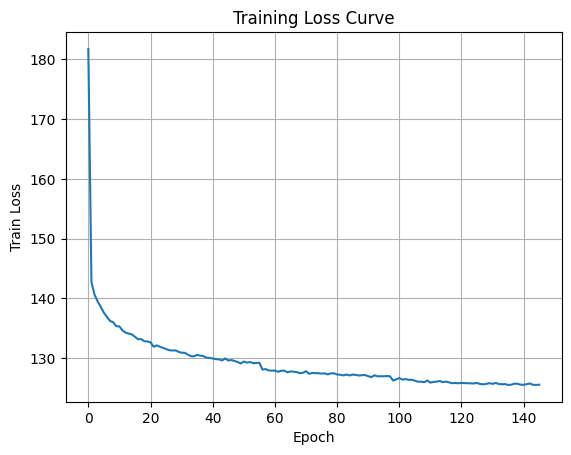

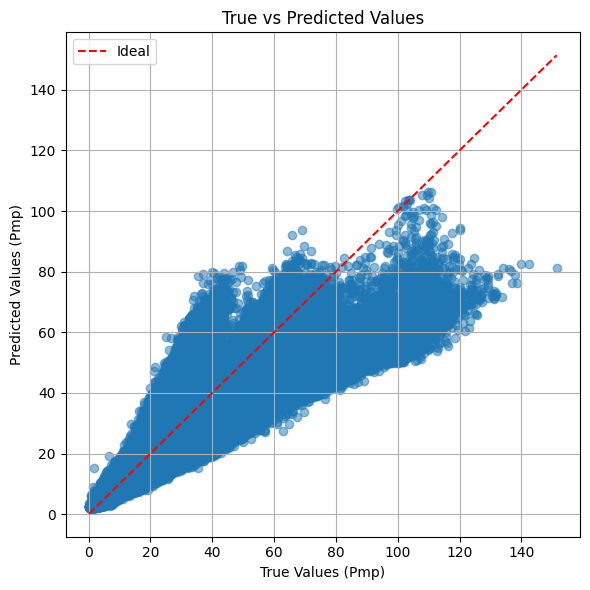

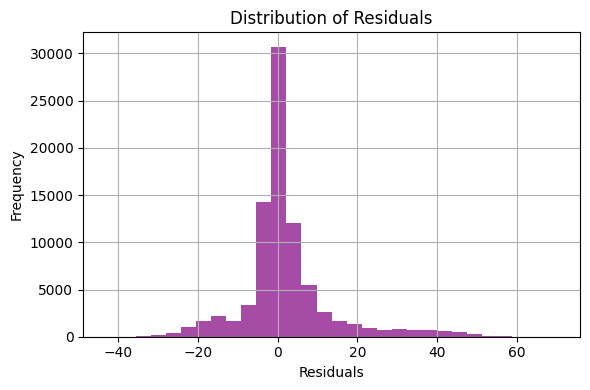

In [6]:
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
criterion = nn.MSELoss()

epochs = 150
best_loss = np.inf
patience = 10
counter = 0
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_15csv.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

# Cargar mejor modelo
model.load_state_dict(torch.load("best_model_15csv.pth"))

# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    residuals = y_test_np - y_pred

# 📈 Gráfica de la pérdida
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 📈 Scatter plot: Predicciones vs Reales
plt.figure(figsize=(6,6))
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', label='Ideal')
plt.xlabel("True Values (Pmp)")
plt.ylabel("Predicted Values (Pmp)")
plt.title("True vs Predicted Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, alpha=0.7, color='purple')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()